# Convergence Benchmarks

In [1]:
import sys
sys.path.insert(0, '../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_channel import *
from quantum_tools import *
from experimental import *
from spam import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Fit SPAM model

### Generate True Model, Full POVM and Inital

In [2]:
def generate_spam_benchmark(n=3, c1=1, c2=1):
    d = 2**n

    init_target = InitialState(d, c=c1)
    povm_target = POVM(d, c=c2)

    spam_target = SPAM(init = init_target,
                       povm = povm_target)
    
    return spam_target


def generate_spam_data(spam_target, N_spam=None, noise=0):
    n = int(np.log2(spam_target.d))
    inputs_spam, _ = generate_pauliInput_circuits(n)
    N_spam = inputs_spam.shape[0]

    state = tf.repeat(spam_target.init.init[None,:,:], N_spam, axis=0)
    state = apply_unitary(state, inputs_spam)
    targets_spam = measurement(state, povm = spam_target.povm.povm)

    #add noise
    targets_spam = add_noise_to_probs(targets_spam, noise=noise)
    return inputs_spam, targets_spam


def generate_map_data(channel_target, spam_target, N_map=None, noise=0):
    n = channel_target.n
    inputs_map, _ = generate_pauli_circuits(n = n, 
                                            circuit_target=None,  
                                            trace=False,
                                            N=N_map)
    U_prep, U_basis = inputs_map

    N_map = U_prep.shape[0]
    state = tf.repeat(tf.expand_dims(spam_target.init.init, axis=0), N_map, axis=0)
    state = apply_unitary(state, U_prep)
    state = channel_target.apply_channel(state)
    targets_map = measurement(state, U_basis, spam_target.povm.povm)
    
    return inputs_map, targets_map


def povm_fidelity(povm_a, povm_b):
    d = povm_a.shape[0]
    ab = tf.matmul(povm_a, povm_b)
    ab_sqrt = tf.linalg.sqrtm(ab)
    fidelity = tf.math.reduce_sum(tf.linalg.trace(ab_sqrt))/d
    return fidelity


## Three Qubit

In [4]:
n = 3
d = 2**n
c1 = 0.8
c2 = 0.8

num_reps = 1
noise_list = np.logspace(-1, -2, 3)
noise_list= np.append(noise_list, 0)

init_3q_corr = np.zeros((len(noise_list), num_reps))
povm_3q_corr = np.zeros((len(noise_list), num_reps))

for i, noise in tqdm(enumerate(noise_list)):
    
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    
    for rep in range(num_reps):
        spam_target = generate_spam_benchmark(n=n, c1=c1, c2=c2)
        inputs_spam, targets_spam = generate_spam_data(spam_target, N_spam=None, noise=noise)

        spam_model = SPAM(init = InitialState(d),
                          povm = CorruptionMatrix(d),
                          optimizer = tf.optimizers.Adam(learning_rate=0.01))

        spam_model.train(inputs = inputs_spam,
                         targets = targets_spam,
                         num_iter = 1000,
                         verbose = False,
                        )
        
        init_3q_corr[i, rep] = state_fidelity(spam_model.init.init, spam_target.init.init)
        povm_3q_corr[i, rep] = povm_fidelity(spam_model.povm.povm, spam_target.povm.povm)
        
saver(init_3q_corr, "init_3q_corr.p")
saver(povm_3q_corr, "povm_3q_corr.p")

0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.007688781416526464


C:\Program Files\Anaconda3\envs\env_qiskit\lib\site-packages\tensorflow\python\framework\ops.py:1062: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0008999677039292536


  0%|          | 0/1000 [00:00<?, ?it/s]

0.00022245998850837449


  0%|          | 0/1000 [00:00<?, ?it/s]

0.00013613539882227017


In [ ]:
n = 3
d = 2**n
c1 = 0.8
c2 = 0.8

num_reps = 1
noise_list = np.logspace(-1, -2, 5)
noise_list= np.append(noise_list, 0)

init_3q_povm = np.zeros((len(noise_list), num_reps))
povm_3q_povm = np.zeros((len(noise_list), num_reps))

for i, noise in tqdm(enumerate(noise_list)):
    
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    
    for rep in range(num_reps):
        spam_target = generate_spam_benchmark(n=n, c1=c1, c2=c2)
        inputs_spam, targets_spam = generate_spam_data(spam_target, N_spam=None, noise=noise)

        spam_model = SPAM(init = InitialState(d),
                          povm = POVM(d),
                          optimizer = tf.optimizers.Adam(learning_rate=0.01))

        spam_model.train(inputs = inputs_spam,
                         targets = targets_spam,
                         num_iter = 2000,
                        )
        
        init_3q_povm[i, rep] = state_fidelity(spam_model.init.init, spam_target.init.init)
        povm_3q_povm[i, rep] = povm_fidelity(spam_model, spam_target)
        
saver(init_3q_povm, "init_3q_povm.p")
saver(povm_3q_povm, "povm_3q_povm.p")

## Four Qubit

In [48]:
n = 4
d = 2**n
c1 = 0.8
c2 = 0.8

num_reps = 1
noise_list = np.logspace(-1, -2, 5)
noise_list= np.append(noise_list, 0)

init_4q_corr = np.zeros((len(noise_list), num_reps))
povm_4q_corr = np.zeros((len(noise_list), num_reps))

for i, noise in tqdm(enumerate(noise_list)):
    
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    
    for rep in range(num_reps):
        spam_target = generate_spam_benchmark(n=n, c1=c1, c2=c2)
        inputs_spam, targets_spam = generate_spam_data(spam_target, N_spam=None, noise=noise)

        spam_model = SPAM(d=d,
                      use_corr_mat=True,
                      optimizer = tf.optimizers.Adam(learning_rate=0.01))

        spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                            num_iter = 300,
                            verbose = False,
                            )

        spam_model.train(inputs = inputs_spam,
                         targets = targets_spam,
                         num_iter = 2000,
                         verbose = False,
                        )
        
        init_4q_corr[i, rep] = state_fidelity(spam_model.init, spam_target.init)
        povm_4q_corr[i, rep] = povm_fidelity(spam_model, spam_target)
        
saver(init_4q_corr, "init_4q_corr.p")
saver(povm_4q_corr, "povm_4q_corr.p")

0it [00:00, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.12963845712686461


  0%|          | 0/2000 [00:00<?, ?it/s]

0.040977978694882386


  0%|          | 0/2000 [00:00<?, ?it/s]

0.013760763837004435


  0%|          | 0/2000 [00:00<?, ?it/s]

0.005225060206693787


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0025316824835169686


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0012693031993364994


In [55]:
n = 4
d = 2**n
c1 = 0.8
c2 = 0.8

num_reps = 1
noise_list = np.logspace(-1, -2, 5)
noise_list= np.append(noise_list, 0)

init_4q_povm = np.zeros((len(noise_list), num_reps))
povm_4q_povm = np.zeros((len(noise_list), num_reps))

for i, noise in tqdm(enumerate(noise_list)):
    
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    
    for rep in range(num_reps):
        spam_target = generate_spam_benchmark(n=n, c1=c1, c2=c2)
        inputs_spam, targets_spam = generate_spam_data(spam_target, N_spam=None, noise=noise)

        spam_model = SPAM(d=d,
#                      use_corr_mat=True,
                      optimizer = tf.optimizers.Adam(learning_rate=0.01))

        spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                            num_iter = 300,
                            verbose = False,
                            )

        spam_model.train(inputs = inputs_spam,
                         targets = targets_spam,
                         num_iter = 2000,
                         verbose = False,
                        )
        
        init_4q_povm[i, rep] = state_fidelity(spam_model.init, spam_target.init)
        povm_4q_povm[i, rep] = povm_fidelity(spam_model, spam_target)
        
saver(init_4q_povm, "init_4q_povm.p")
saver(povm_4q_povm, "povm_4q_povm.p")

0it [00:00, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.11242529930228881


C:\Users\krist\anaconda3\envs\env_qiskit\lib\site-packages\tensorflow\python\framework\ops.py:1064: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


  0%|          | 0/2000 [00:00<?, ?it/s]

0.03384224433521337


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01042494253788658


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003258788781533387


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0010275153082765452


  0%|          | 0/2000 [00:00<?, ?it/s]

6.28307093666071e-06


In [8]:
print(init_3q_corr)

[[0.9733]
 [0.9913]
 [0.9936]
 [0.9939]]


ValueError: x and y must have same first dimension, but have shapes (3,) and (4,)

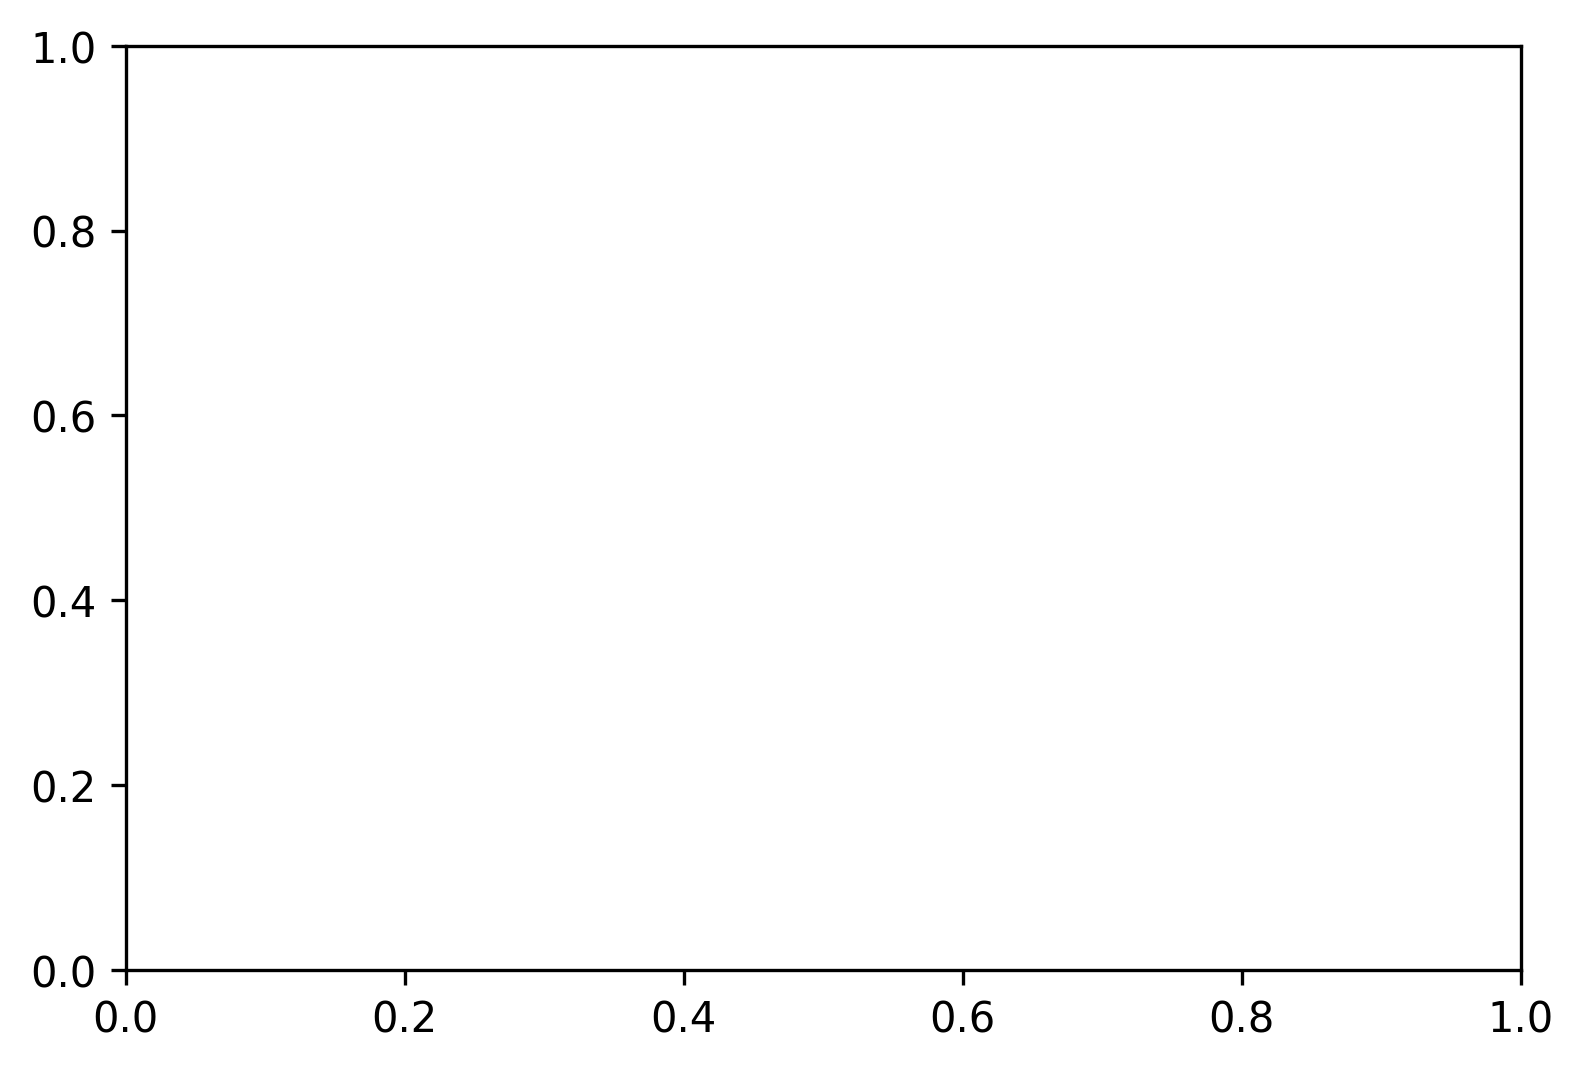

In [7]:
init_3q_corr = loader("init_3q_corr.p")
#init_3q_povm = loader("init_3q_povm.p")

povm_3q_corr = loader("povm_3q_corr.p")
#povm_3q_povm = loader("povm_3q_povm.p")

#init_4q_corr = loader("init_4q_corr.p")
#init_4q_povm = loader("init_4q_povm.p")

#povm_4q_corr = loader("povm_4q_corr.p")
#povm_4q_povm = loader("povm_4q_povm.p")


shots_list = list(1/noise_list[:-1]**2)

init_3q_corr_avg = np.mean(init_3q_corr, axis=1)
#init_3q_povm_avg = np.mean(init_3q_povm, axis=1)

#init_4q_corr_avg = np.mean(init_4q_corr, axis=1)
#init_4q_povm_avg = np.mean(init_4q_povm, axis=1)

povm_3q_corr_avg = np.mean(povm_3q_corr, axis=1)
#povm_3q_povm_avg = np.mean(povm_3q_povm, axis=1)

#povm_4q_corr_avg = np.mean(povm_4q_corr, axis=1)
#povm_4q_povm_avg = np.mean(povm_4q_povm, axis=1)

ticks_list = [0,1,2,3,4,5]
labels = ["$10^2$","$3.2 x 10^2$","$10^3$","$3.2 x 10^3$","$10^4$","$\infty$"]

fig = plt.figure(figsize=(6, 4), dpi=300, facecolor="w", edgecolor="k")
#plt.plot(ticks_list, init_3q_povm_avg, "bo-")
plt.plot(ticks_list, init_3q_corr_avg, "bo--")

#plt.plot(ticks_list, init_4q_povm_avg, "ro-")
#plt.plot(ticks_list, init_4q_corr_avg, "ro--")

plt.xticks(ticks_list, labels)
plt.ylim([0.9, 1])

plt.xlabel("#Shots")
plt.ylabel("Fidelity")
plt.legend(["Quantum POVM, Three Qubits", "Classical POVM, Three Qubits", 
           "Quantum POVM, Four Qubits", "Classical POVM, Four Qubits",])


plt.grid()
plt.savefig("SPAM_recovery_shots_sensitivy_init.pdf")
plt.show()


fig = plt.figure(figsize=(6, 4), dpi=300, facecolor="w", edgecolor="k")
#plt.plot(ticks_list, povm_3q_povm_avg, "bo-")
plt.plot(ticks_list, povm_3q_corr_avg, "bo--")

#plt.plot(ticks_list, povm_4q_povm_avg, "ro-")
#plt.plot(ticks_list, povm_4q_corr_avg, "ro--")

plt.xticks(ticks_list, labels)
plt.ylim([0.9, 1])

plt.xlabel("#Shots")
plt.ylabel("Fidelity")
plt.legend(["Quantum POVM, Three Qubits", "Classical POVM, Three Qubits", 
           "Quantum POVM, Four Qubits", "Classical POVM, Four Qubits",])


plt.grid()
plt.savefig("SPAM_recovery_shots_sensitivy_povm.pdf")
plt.show()